New blaze calibrations were made in 2020! Can we make the best E140M spectrum ever?

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
import scipy.interpolate as interpolate
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [10]:
data = fits.getdata('data/odlc02010_x1d.fits',1)

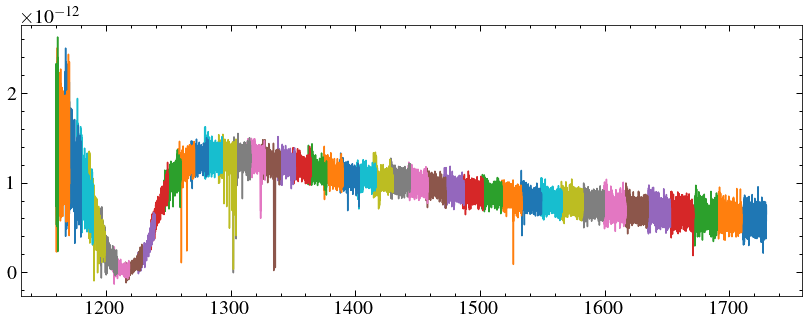

In [19]:
for dt in data:
    mask = dt['WAVELENGTH'] > 1160
    plt.plot(dt['WAVELENGTH'][mask][5:-6], dt['FLUX'][mask][5:-6])

In [18]:
import stisblazefix

In [13]:
plt.rcParams.update({"text.usetex": False})

stisblazefix.fluxfix(['data/odlc02010_x1d.fits'], 'v727car_test.pdf')

plt.rcParams.update({"text.usetex": True})

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


In [14]:
data1 = fits.getdata('data/odlc02010_x1f.fits',1)

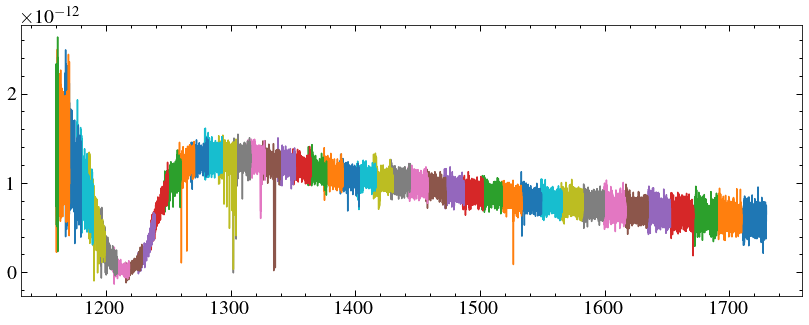

In [15]:
for dt in data1:
    mask = dt['WAVELENGTH'] > 1160
    plt.plot(dt['WAVELENGTH'][mask][5:-6], dt['FLUX'][mask][5:-6])

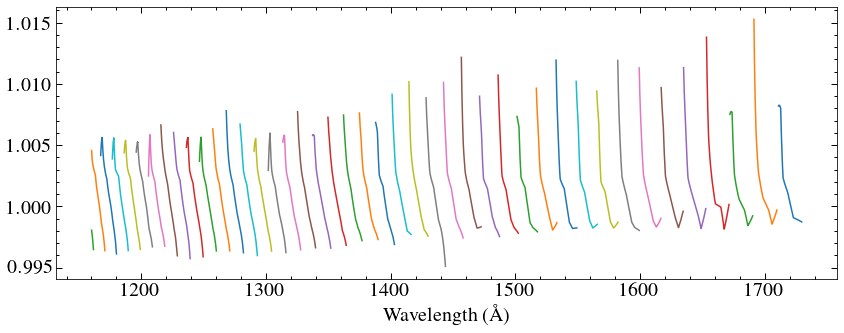

In [16]:
for i in range(len(data1)):
    dt1 = data1[i]
    dt0 = data[i]
    mask = dt0['WAVELENGTH'] > 1160
    plt.plot(dt0['WAVELENGTH'][mask][5:-6], dt0['FLUX'][mask][5:-6]/dt1['FLUX'][mask][5:-6])
    plt.xlabel('Wavelength (\AA)')

Ok, now stich, but a new array retaining the ratios between the two.

In [76]:
def spectra_adder(f_array, e_array, scale_correct=True):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    if scale_correct:
        error = (var * rcs)**0.5
    else:
        error = var**2
    return flux,error

def echelle_coadd(wavelength, flux, err, nclip =5, find_ratio =True):
    """
    combines echelle orders into one spectrum, stiching them together at the overlap 
    """
    #slice dodgy ends off orders (usually 5-10 for stis el40m)
    wavelength = wavelength[:, nclip:-(nclip+1)]
    flux = flux[:, nclip:-(nclip+1)]
    err = err[:, nclip:-(nclip+1)]
    
    #new arrays to put the output in
    w_full = np.array([], dtype=float)
    f_full = np.array([], dtype=float)
    e_full = np.array([], dtype=float)
    if find_ratio:
        r_full = np.array([], dtype=float) #ratio between orders

    shape = np.shape(flux)
    order = 0
    while order < (shape[0]):
        
        #first add the part that does not overlap ajacent orders to the final spectrum
        if order == 0: #first and last orders do not overlap at both ends
            overmask = (wavelength[order] > wavelength[order + 1][-1])
        elif order == shape[0]-1:
            overmask = (wavelength[order] < wavelength[order - 1][1])
        else:
            overmask = (wavelength[order] > wavelength[order + 1][-1]) & (wavelength[order] < wavelength[order - 1][1])
        w_full = np.concatenate((w_full, wavelength[order][overmask]))
        f_full = np.concatenate((f_full, flux[order][overmask]))
        e_full = np.concatenate((e_full, err[order][overmask]))
        if find_ratio:
            r_full = np.concatenate((r_full, np.full(len(err[order][overmask]), -1)))
  
        if order != shape[0]-1:
            
            #interpolate each order onto the one beneath it, with larger wavelength bins. Code adapted from stisblazefix
            f = interpolate.interp1d(wavelength[order + 1], flux[order + 1], fill_value='extrapolate')
            g = interpolate.interp1d(wavelength[order + 1], err[order + 1], fill_value='extrapolate')
            overlap = np.where(wavelength[order] <= wavelength[order + 1][-1])
            f0 = flux[order][overlap]
            f1 = f(wavelength[order][overlap])
            g0 = err[order][overlap]
            g1 = g(wavelength[order][overlap])
       
             
            #combine flux and error at overlap and add to final spectrum
            w_av = wavelength[order][overlap]
            f_av, e_av = spectra_adder(np.array([f0,f1]),np.array([g0,g1]))
            w_full = np.concatenate((w_full, w_av))
            f_full = np.concatenate((f_full, f_av))
            e_full = np.concatenate((e_full, e_av))
            if find_ratio:
                r_full = np.concatenate((r_full, f0/f1))
        order += 1
    
    #stis orders are saved in reverse order, so combined spectra are sorted by the wavelength array
    arr1inds = w_full.argsort()
    sorted_w = w_full[arr1inds]
    sorted_f = f_full[arr1inds]
    sorted_e = e_full[arr1inds]
    if find_ratio:
        sorted_r = r_full[arr1inds]
 
    if find_ratio:
        return sorted_w, sorted_f, sorted_e, sorted_r
    else:
        return sorted_w, sorted_f, sorted_e

In [77]:
w, f, e, r = echelle_coadd(data1['WAVELENGTH'], data1['FLUX'], data1['ERROR'], nclip=5)

(1206.0, 1207.0)

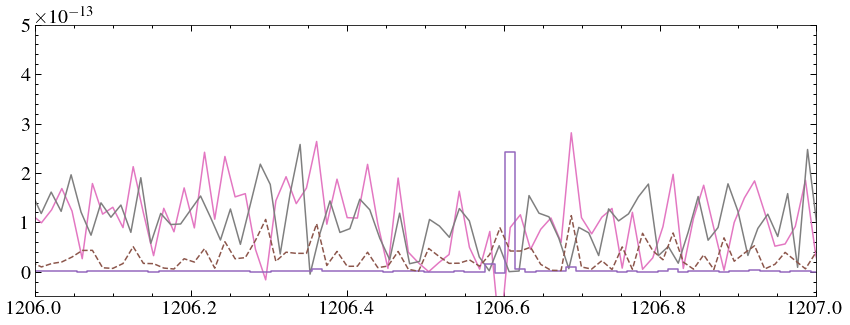

In [90]:
for dt in data1:
    mask = dt['WAVELENGTH'] > 1160
    plt.plot(dt['WAVELENGTH'][mask][5:-6], dt['FLUX'][mask][5:-6])
#     print(len(dt['FLUX'][dt['FLUX'] < 0]))

plt.step(w[r!=-1], r[r!=-1]*1e-15, where='mid')
plt.plot(w,e, ls='--')
# plt.yscale('log')
# plt.ylim(0, 10)
plt.ylim(-0.5e-13, 0.5e-12)
plt.xlim(1206, 1207)

1.0985551459362788 0.9969090165071081 3.84371816046052


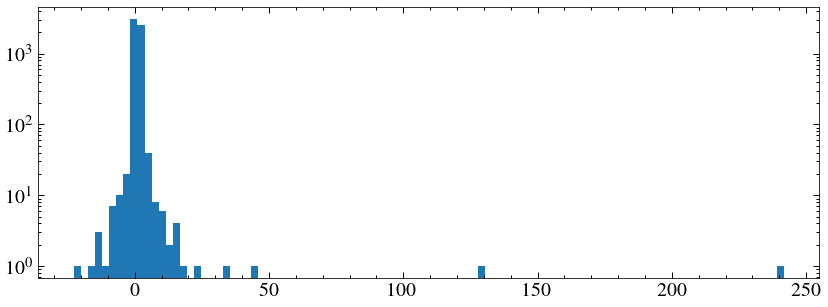

In [87]:
mask = (r != -1)
plt.hist(r[mask], bins=100)
print(np.mean(r[mask]), np.median(r[mask]), np.std(r[mask]))
plt.yscale('log')

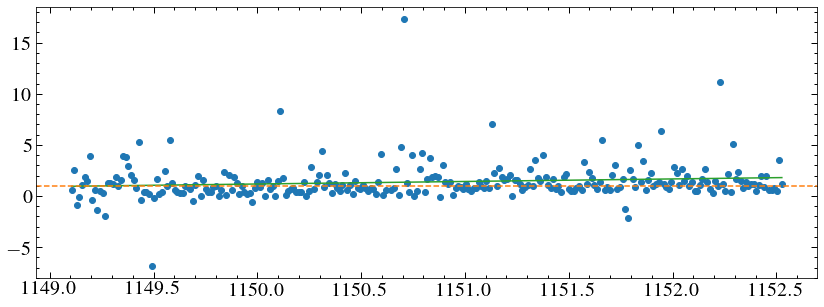

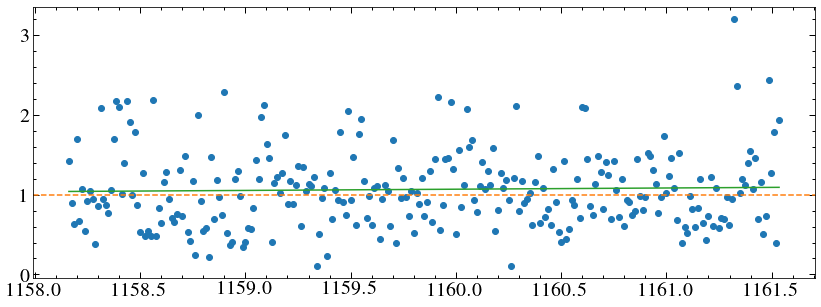

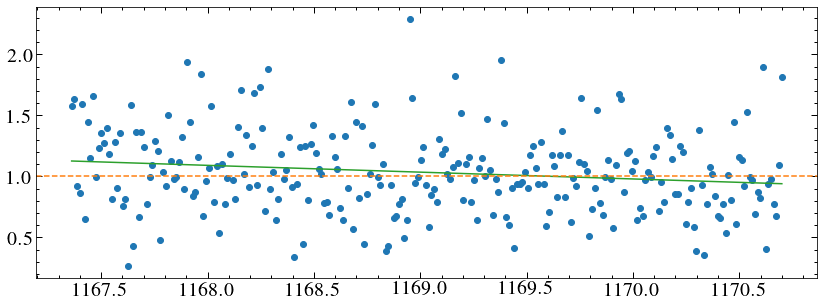

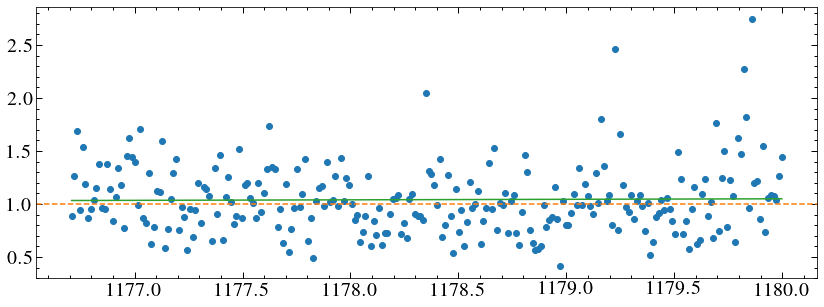

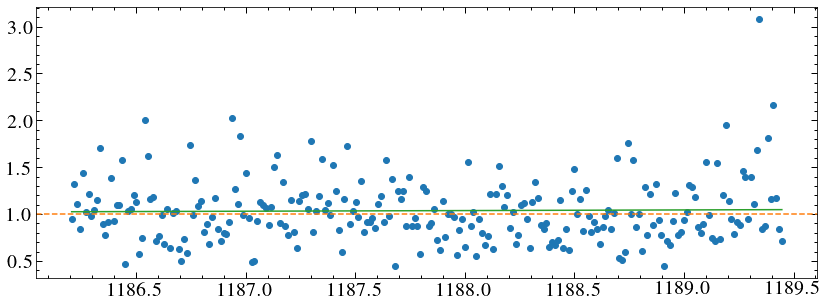

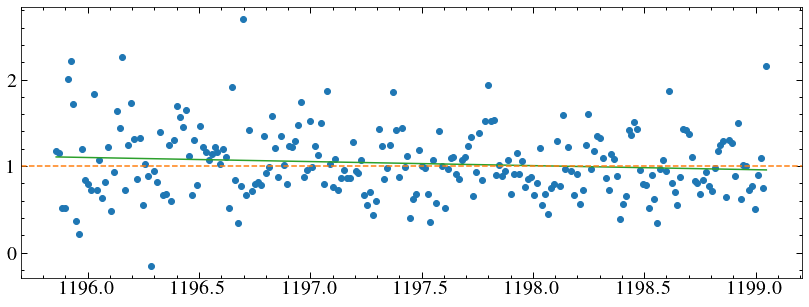

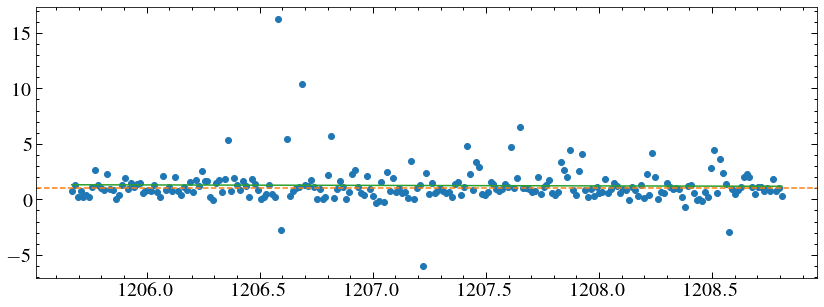

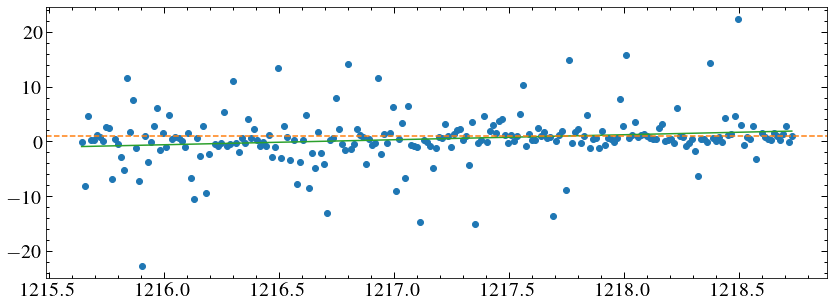

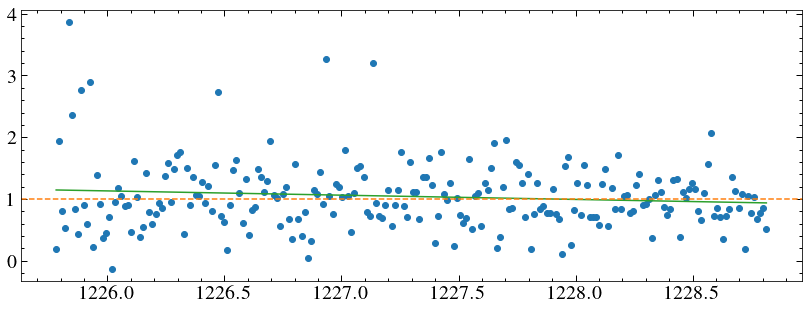

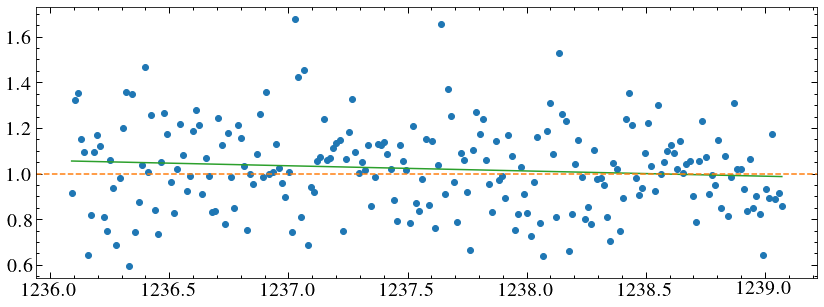

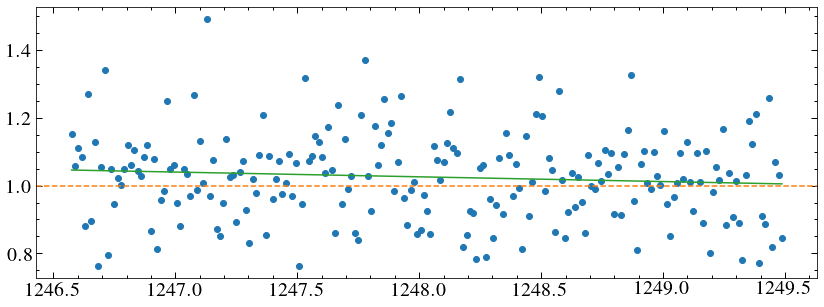

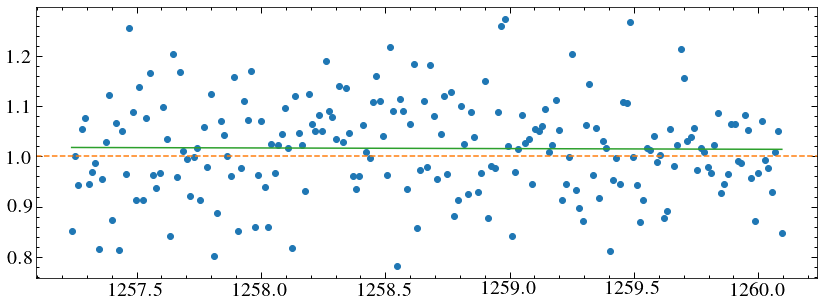

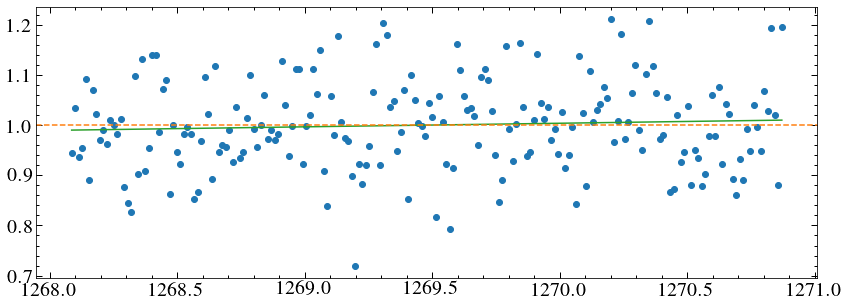

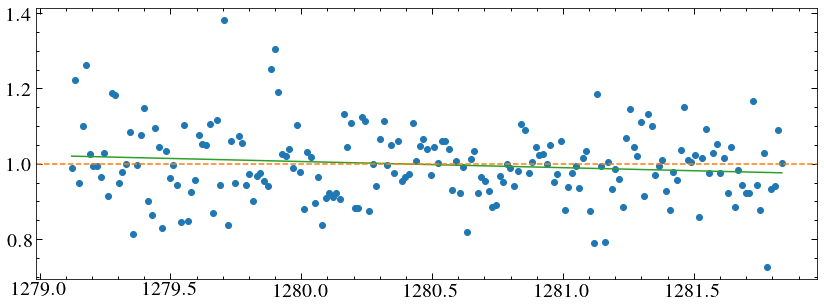

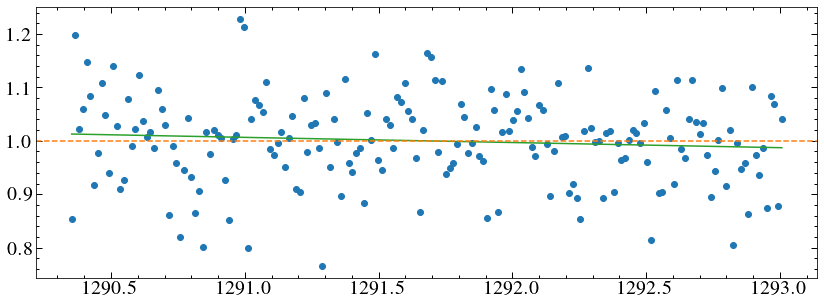

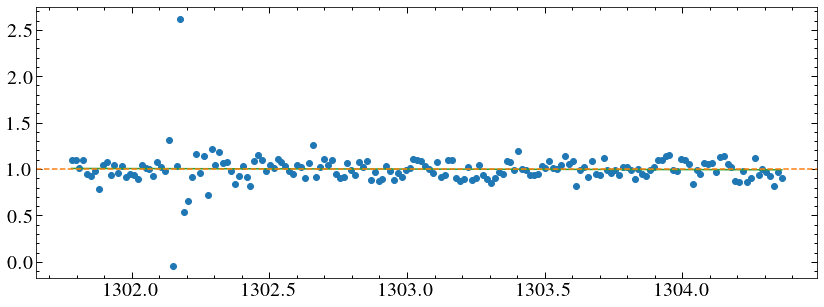

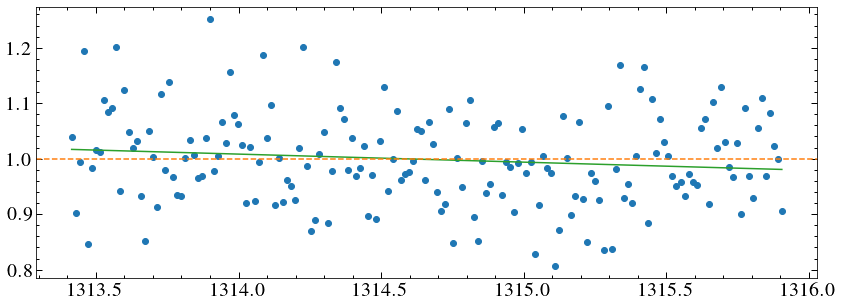

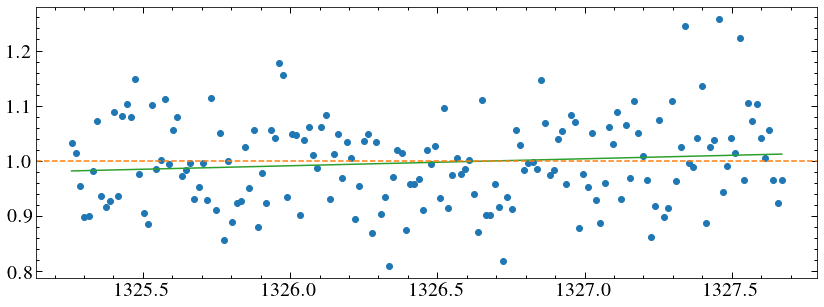

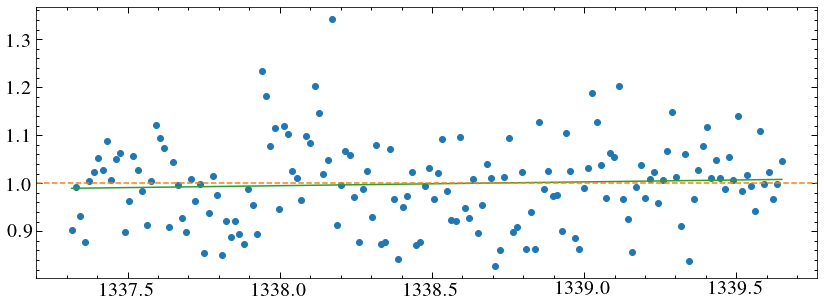

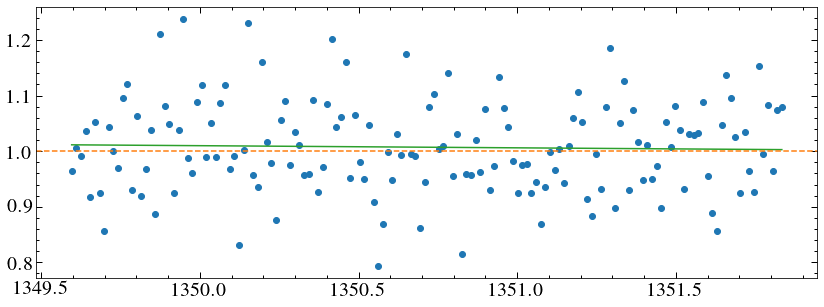

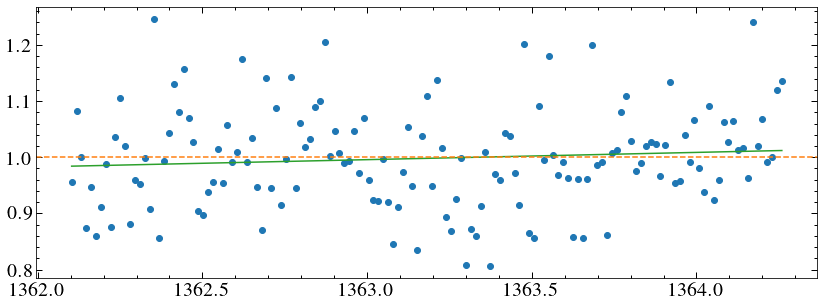

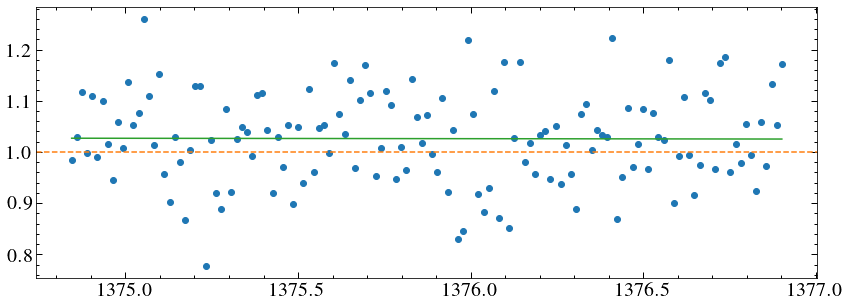

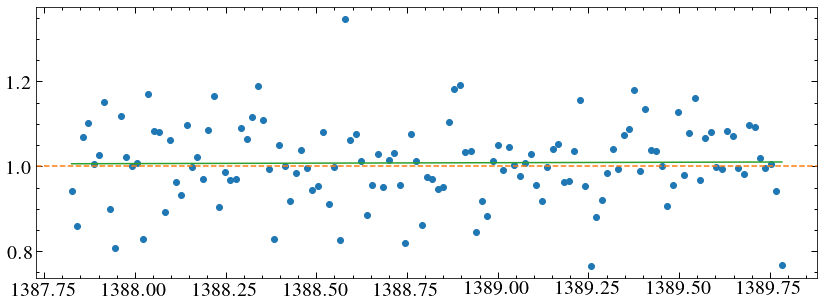

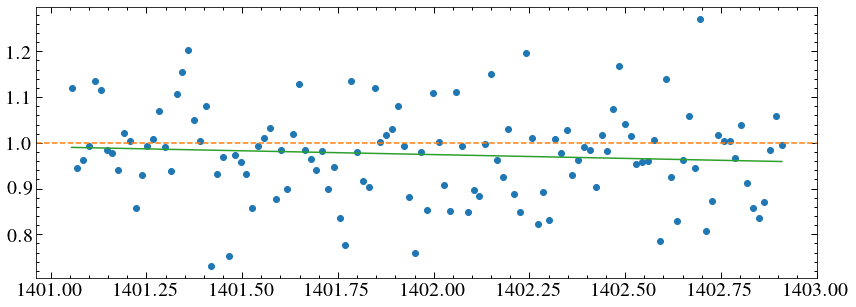

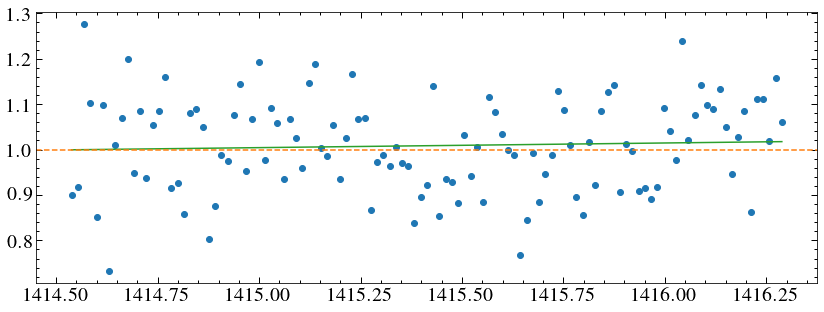

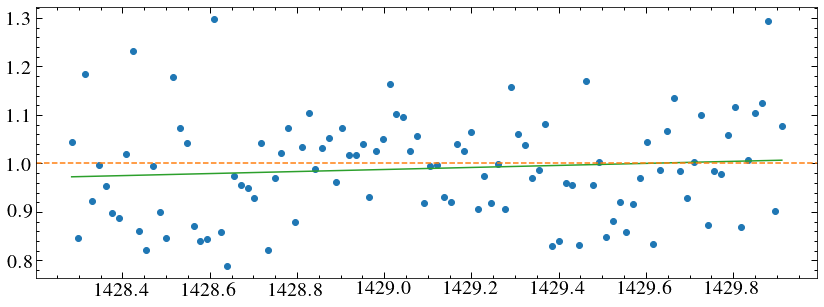

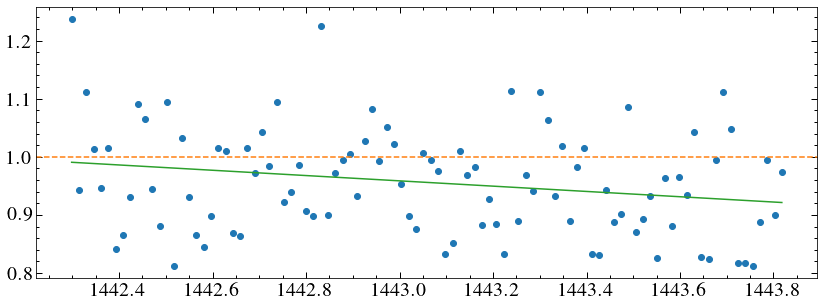

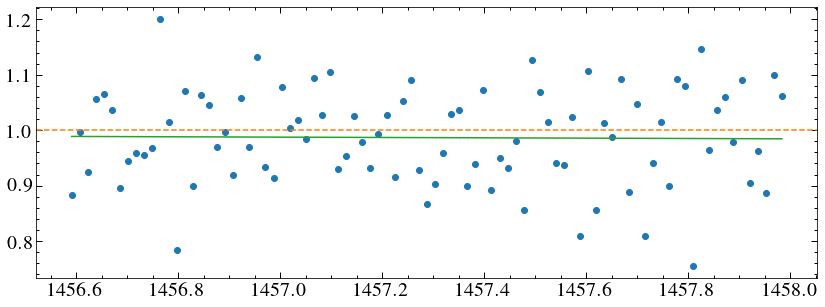

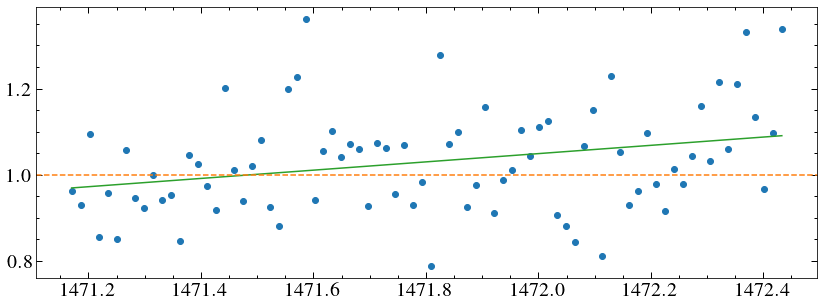

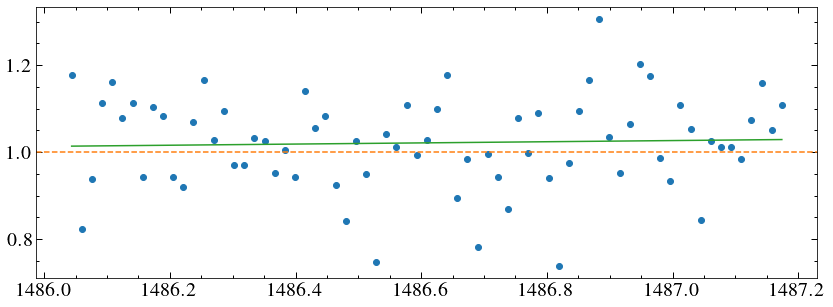

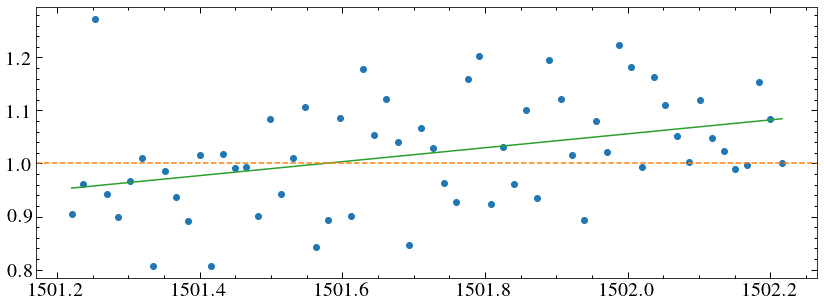

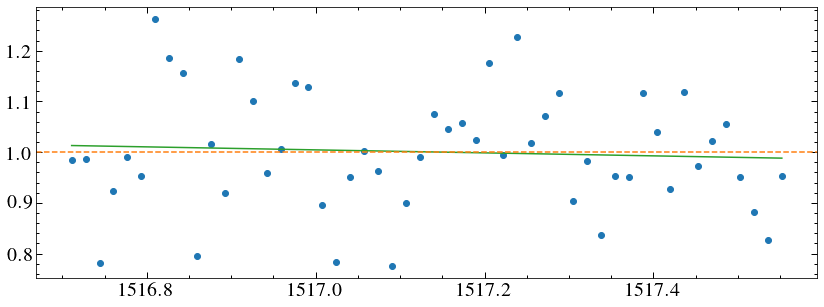

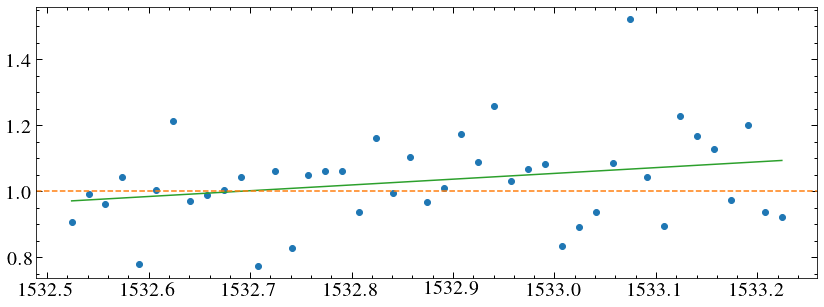

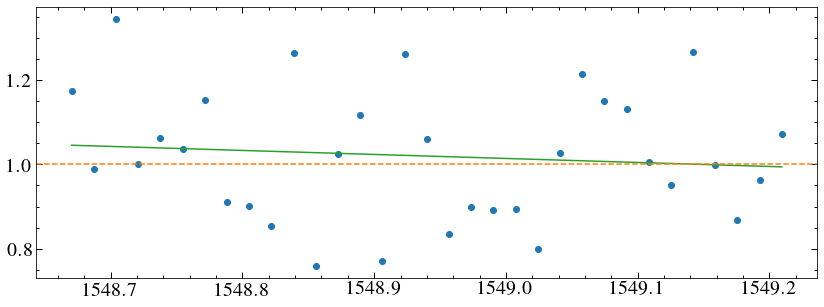

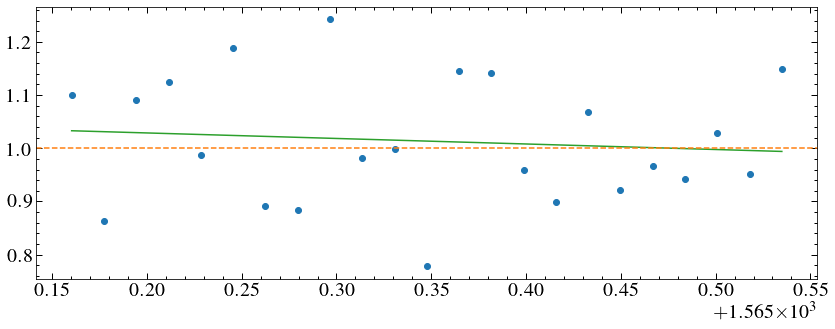

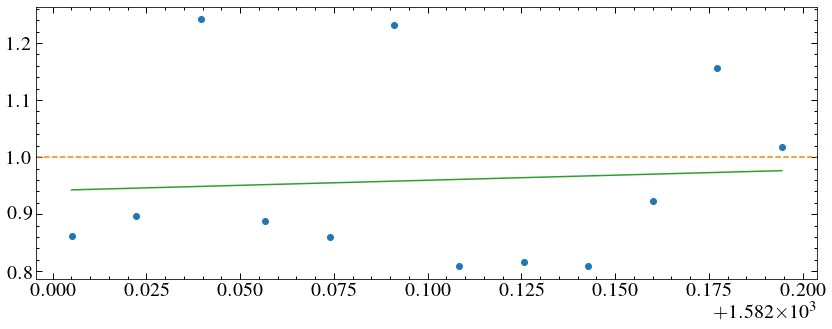

IndexError: index 5736 is out of bounds for axis 0 with size 5736

In [99]:
fitter = fitting.LinearLSQFitter()
line_init = models.Linear1D()
mask = (r != -1)# & ( w< 1200)
wr, rr = w[mask], r[mask]
cw = []
cr = []
for i in range(len(rr)):
    if wr[i+1] - wr[i] < 2:
        cw.append(wr[i])
        cr.append(rr[i])
    else:
        cw, cr = np.array(cw), np.array(cr)
        plt.scatter(cw[cr < 30], cr[cr < 30])
        fitted_line = fitter(line_init, cw[cr < 30], cr[cr < 30])
        plt.plot(cw, fitted_line(cw), c='C2')
    
        plt.axhline(1, ls = '--', c='C1')
        
        plt.show()
        cw = []
        cr = []